In [4]:
from astropy.io import fits
from astropy.time import Time
from astropy import units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import mpcorbget as mpc
import os

Requires:
    * AstroPy
    * mpcorbget

In [5]:
observatory = 695 #kitt peak
designation = 2029 #binomi
root = "BinomiPhotometryFiles/fixed/"
VERBOSE = 0

In [6]:
#display img function
def printImg(img):
    plt.imshow(img, interpolation="nearest", vmin=img.mean(), vmax=2*img.mean())
    plt.gray()
    plt.colorbar()
    plt.show()

This next cell initializes a python package I wrote that calculates the position of an asteroid at a specified time given its designation. To see the code for this see: https://github.com/davenporta/mpcorbget. If you don't have this package (you probably don't) type `pip install mpcorbget` in your command line. Note that this method will only work if the target is an asteroid, otherwise this will require a plate solving algorithm or manual entry.

In [7]:
ast = mpc.MPCORB(designation)

----------------------------------------------
Fetching MPCORB.DAT
SUCCESS


In [8]:
main = os.listdir(root)

for folder in main:
    files = os.listdir(root+folder+"/")
    print("Current folder: {}".format(folder))
    for image in files:
        if VERBOSE == 1:
            print("    Cleaning {}".format(image))
        with fits.open(root+folder+"/"+image, 'update') as cal_hdu:
            cal_header = cal_hdu[0].header
            aptime = Time(cal_header["MJD-OBS"],format="mjd")
            coords = ast.geocentric(aptime.iso).split()[1::2]
            cal_header["RA"] = coord.Angle(coords[0], unit='hourangle').to_string(sep=":", pad=True)
            cal_header["DEC"] = coord.Angle(coords[1], unit=u.deg).to_string(sep=":", pad=True, alwayssign=True)
            cal_header["DATE-OBS"] = aptime.fits[:-5]
            cal_header["EQUINOX"] = 2000.0
            cal_header["RADECSYS"] = "FK5"
print("-----------------------------\nFITS header repair completed")


Current folder: Oct21BinomiBlueConverted
Current folder: Oct21BinomiGreenConverted
Current folder: Oct21BinomiIRConverted
Current folder: Oct21BinomiRedConverted
-----------------------------
FITS header repair completed


I've added RA, DEC, DATE-OBS, EQUINOX, RADECSYS to the fits header. I was able to simply convert the modified julian date, which was preserved by your conversion program instead of having to copy the time from the preconversion images. Note that the DATE tag is NOT the start of the exposure, rather the time the file was created, which is usually a few seconds after the exposure ends. Below is the final fits header. Note that whatever program created this image fills the header with hundreds of lines of quite useless information.

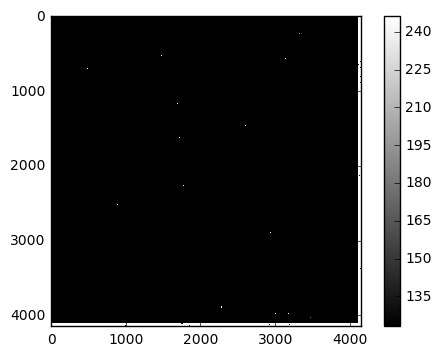

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 4150 / Axis length                                    
NAXIS2  =                 4150 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =   1.0000000000000000 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =   32768.000000000000 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2016-10-23T08:36:23' / Date FITS file was generated                  
IRAF-TLM= '2016-10-23T08:36:22' / Time of last modification                     
OBJECT  = 'Orphan Stream field2' / Name of the object observed                  
NEXTEND =                   

In [11]:
#load cal image
hdu = fits.open(root+'Oct21BinomiBlueConverted/c7683t0082o00-cal.fit')
header = hdu[0].header
img = hdu[0].data

printImg(img)
header